In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
from sklearn import (metrics,preprocessing,manifold,decomposition,model_selection)
from scipy import interpolate
import matplotlib.cm as cmx
from mpl_toolkits.mplot3d import Axes3D
from keras.models import (Sequential,Model)

from keras.layers import (Dense, Dropout, Activation, Conv1D, Flatten,Input,Reshape,UpSampling1D)
from keras.layers import (MaxPooling1D,BatchNormalization,LeakyReLU)
from keras.optimizers import SGD,Adam,RMSprop
import keras
from keras.backend import tensorflow_backend as backend
from keras import backend as K
from collections import namedtuple
from scipy.signal import medfilt

print(backend.device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6048408176521768638
]


In [94]:
FilterConfiguration=namedtuple("FilterConfiguration",["type","windowSize"])


class RamanSample:
    def __init__(self,spectrum, wavenumbers,type,name):
        self.spectrum=spectrum
        self.wavenumbers=wavenumbers
        self.type=type
        self.name=name
    
    def prettyName(self):
        components=self.name.split("_")
        return "{}_{}".format(components[0],components[-2])
    
    def interpolatedSpectra(self,startWN,endWN,points,scale=None,removeBackground=False,filterConfiguration:FilterConfiguration=None):
        newX = np.linspace(start=startWN, stop=endWN, num=points)
        interpolator = interpolate.interp1d(self.wavenumbers, self.spectrum, axis=0)
        newY = interpolator(newX)
        
        if filterConfiguration is not None:
            newYY=np.copy(newY)
            
            if filterConfiguration.type is "median":
                f=medfilt(newYY,kernel_size=filterConfiguration.windowSize)
                newY=f
                
                
        if removeBackground is True:
            newY=self.removeBackground(newY)
            
        if scale == "minmax":
            newY=preprocessing.minmax_scale(newY, axis=0, copy=True)
        elif scale == "normalize":
            newY=preprocessing.scale(newY, axis=0, copy=True)
        return newY
    
    def makeMD(self,shape):
        M_D = np.zeros((shape[0] - 1, shape[0]))
        for p in range(M_D.shape[0]):  # this should work more elegantly without loops!
            for q in range(M_D.shape[1]):
                if p == q:
                    M_D[p, q] = -1
                elif p == q - 1:
                    M_D[p, q] = 1
                else:
                    M_D[p, q] = 0
        return M_D

    def removeBackground(self,inVector,lambdaVal=1000, pVal=0.1,M_D=None):

        inVectorDuplicate=np.copy(inVector)

        if M_D is None:
           M_D=self.makeMD(inVector.shape)


        W_One=np.ones_like(inVector)
        M_Diagonal=np.diag(W_One)
        stopVal=3
        M_B=np.zeros_like(inVector)
        for _ in range(0,stopVal):
            L=(M_Diagonal + lambdaVal * np.transpose(M_D) @ M_D)
            weightedIn=W_One * inVectorDuplicate
            M_B=np.linalg.solve(L,weightedIn)

            W_One = np.where(inVectorDuplicate < M_B, pVal, 1-pVal)

        result=inVectorDuplicate-M_B

        return result
    


In [95]:
sporePath="/Users/morten/Documents/Raman/20170630/spore_quartz.txt"
coliPath="/Users/morten/Documents/Raman/20170630/ecoli_quartz.txt"
yeastPath="/Users/morten/Documents/Raman/20170630/yeast_quartz.txt"

sporeData=np.loadtxt(sporePath,skiprows=1,unpack=True)
sporeSamples=[]

with open(sporePath, "r") as file:
    sporeNames=file.readline().split()

for idx in range(1,sporeData.shape[0],2):
    spore=RamanSample(sporeData[idx-1],sporeData[idx],type=0,name=sporeNames[idx-1])
    sporeSamples.append(spore)

coliData=np.loadtxt(coliPath,skiprows=1,unpack=True)
coliSamples=[]

with open(coliPath, "r") as file:
    coliNames=file.readline().split()

for idx in range(1,coliData.shape[0],2):
    coli=RamanSample(coliData[idx-1],coliData[idx],type=1,name=coliNames[idx-1])
    coliSamples.append(coli)

yeastData=np.loadtxt(yeastPath,skiprows=1,unpack=True)
yeastSamples=[]

with open(yeastPath, "r") as file:
    yeastNames=file.readline().split()

for idx in range(1,yeastData.shape[0],2):
    y=RamanSample(yeastData[idx-1],yeastData[idx],type=2,name=yeastNames[idx-1])
    yeastSamples.append(y)


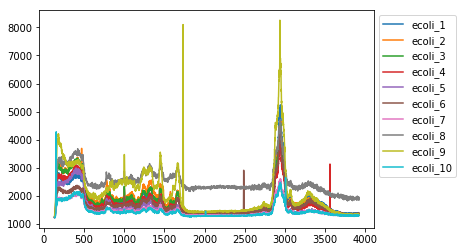

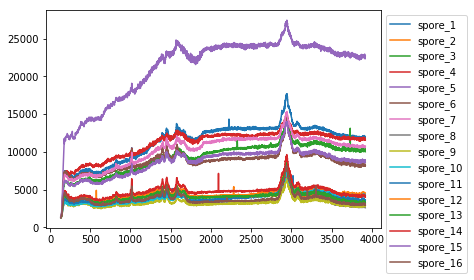

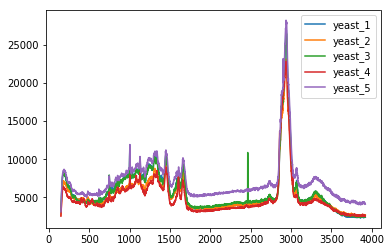

In [96]:
for t in [coliSamples,sporeSamples,yeastSamples]:
    for sample in t:
        plt.plot(sample.wavenumbers,sample.spectrum,label=sample.prettyName())

    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

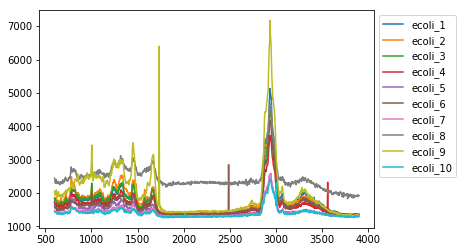

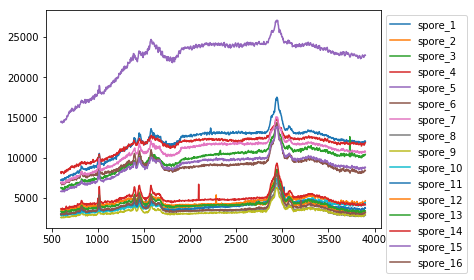

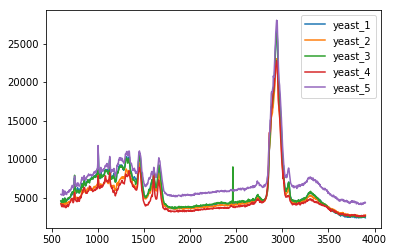

In [97]:
startPNT=600
endPNT=3900
points=1024
newX=np.linspace(startPNT,stop=endPNT,num=points)

for t in [coliSamples,sporeSamples,yeastSamples]:
    for sample in t:
        interp=sample.interpolatedSpectra(startWN=startPNT,endWN=endPNT,points=points)
        plt.plot(newX,interp,label=sample.prettyName())
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()


In [98]:
allData=sporeSamples+coliSamples+yeastSamples
allSpectra=[]
allClasses=[]
for sample in allData:
    interp=sample.interpolatedSpectra(startWN=startPNT,endWN=endPNT,points=points)
    allSpectra.append(interp)
    allClasses.append(sample.type)
    
allSpectra=np.array(allSpectra)


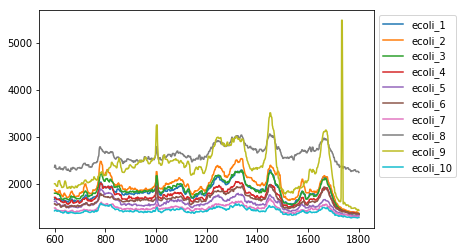

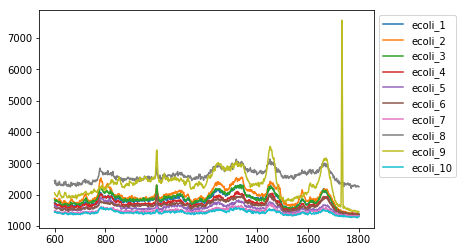

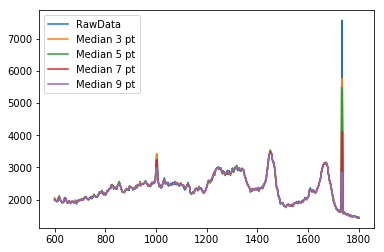

In [106]:
size=5
endPNT=1800
newX=np.linspace(startPNT,stop=endPNT,num=points)

filtered=[]
for sample in coliSamples:
    interp=sample.interpolatedSpectra(startWN=startPNT,endWN=endPNT,points=points)
    f=medfilt(interp,kernel_size=size)
    filtered.append(f)
    plt.plot(newX,f,label=sample.prettyName())
plt.legend(bbox_to_anchor=(1,1))
plt.show()

for sample in coliSamples:
    interp=sample.interpolatedSpectra(startWN=startPNT,endWN=endPNT,points=points)
    plt.plot(newX,interp,label=sample.prettyName())
plt.legend(bbox_to_anchor=(1,1))
plt.show()

sample8Int=coliSamples[8].interpolatedSpectra(startWN=startPNT,endWN=endPNT,points=points)

plt.plot(newX,sample8Int,label="RawData")
for kernel in [3,5,7,9]:
    config=FilterConfiguration(type="median",windowSize=kernel)
    filtered=coliSamples[8].interpolatedSpectra(startWN=startPNT,endWN=endPNT,points=points,filterConfiguration=config)
    plt.plot(newX,filtered,label="Median {} pt".format(kernel))
plt.legend()
plt.show()


In [48]:
types={0:"spore",1:"coli",2:"yeast"}
cmap = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=3)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
handles=[]

for c in types.keys():
    symbol = mlines.Line2D([], [], marker='o', linestyle='None',label=types[c], color=scalarMap.to_rgba(c))
    handles.append(symbol)

def plotResult(x,y,z, title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(title)
    scatter3D=ax.scatter(x,y,z, marker='o', c=allClasses, cmap=cmap,norm=cNorm)
    ax.legend(handles=handles)
    plt.show() 

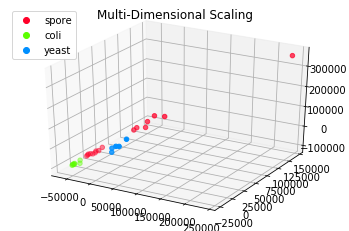

In [100]:
mds=manifold.MDS(n_components=3)
coords=np.hsplit(mds.fit_transform(allSpectra),3)

plotResult(coords[0],coords[1],coords[2],"Multi-Dimensional Scaling")

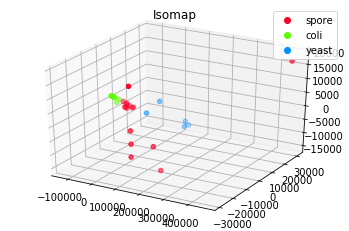

In [101]:
mds=manifold.Isomap(n_components=3)
coords=np.hsplit(mds.fit_transform(allSpectra),3)

plotResult(coords[0],coords[1],coords[2],"Isomap")


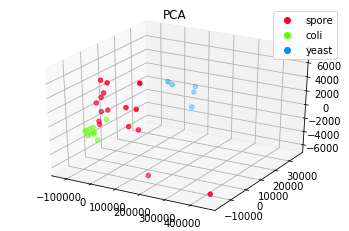

In [102]:
mds=decomposition.PCA(n_components=3)
coords=np.hsplit(mds.fit_transform(allSpectra),3)

plotResult(coords[0],coords[1],coords[2],"PCA")


[t-SNE] Computing 30 nearest neighbors...
[t-SNE] Indexed 31 samples in 0.000s...
[t-SNE] Computed neighbors for 31 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 31 / 31
[t-SNE] Mean sigma: 3582170.815501
[t-SNE] KL divergence after 250 iterations with early exaggeration: 113.970512
[t-SNE] KL divergence after 1000 iterations: 6.961936


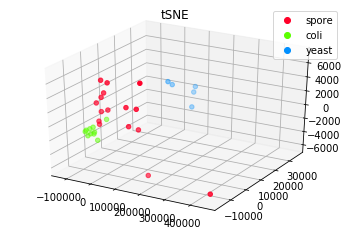

In [103]:
tsnb = manifold.TSNE(n_components=3, verbose=1,init="pca")
coordsTSNB = np.hsplit(tsnb.fit_transform(allSpectra), 3)
plotResult(coordsTSNB[0], coordsTSNB[1], coordsTSNB[2], "tSNE")


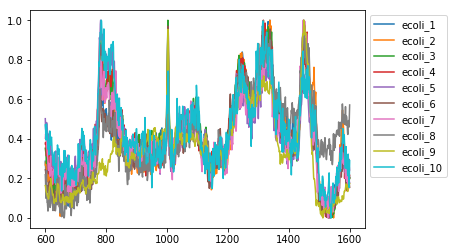

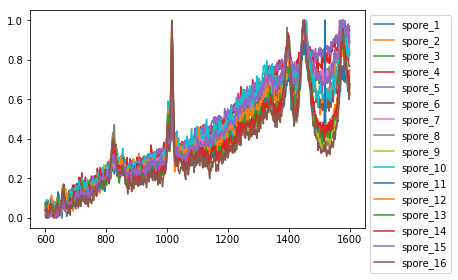

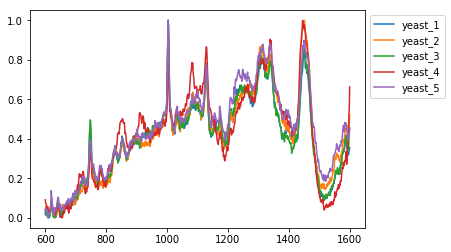

In [104]:
newX=np.linspace(startPNT,stop=endPNT,num=points)
for type in [coliSamples,sporeSamples,yeastSamples]:
    for sample in type:
        interp=sample.interpolatedSpectra(startWN=startPNT,endWN=endPNT,points=points,scale="minmax")
        plt.plot(newX,interp,label=sample.prettyName())
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()


In [105]:
allData=sporeSamples+coliSamples+yeastSamples
allSpectra=[]
allClasses=[]
for sample in allData:
    interp=sample.interpolatedSpectra(startWN=startPNT,endWN=endPNT,points=points)
    allSpectra.append(interp)
    allClasses.append(sample.type)
    
allSpectra=np.array(allSpectra)

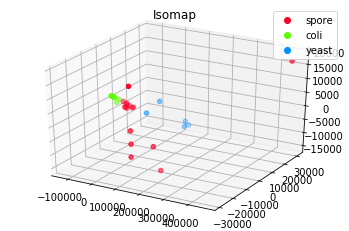

In [106]:
mds=manifold.Isomap(n_components=3)
coords=np.hsplit(mds.fit_transform(allSpectra),3)

plotResult(coords[0],coords[1],coords[2],"Isomap")

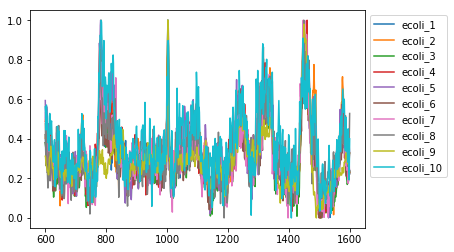

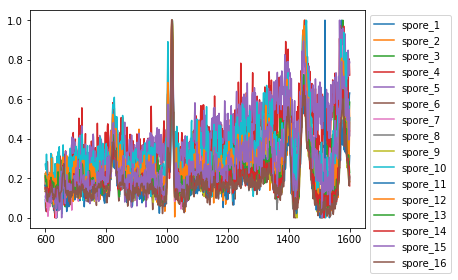

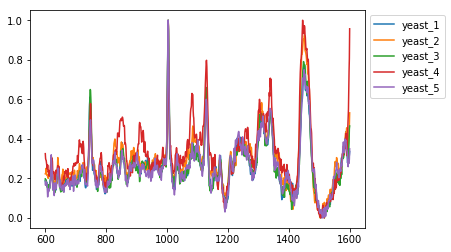

In [107]:
newX=np.linspace(startPNT,stop=endPNT,num=points)

for t in [coliSamples,sporeSamples,yeastSamples]:
    for sample in t:
        interp=sample.interpolatedSpectra(startWN=startPNT,endWN=endPNT,points=points,removeBackground=True,scale="minmax")
        plt.plot(newX,interp,label=sample.prettyName())
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()



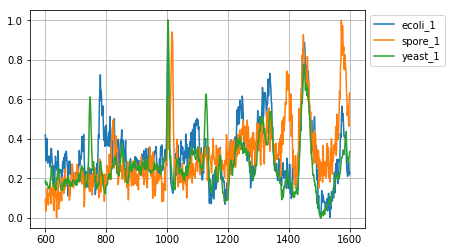

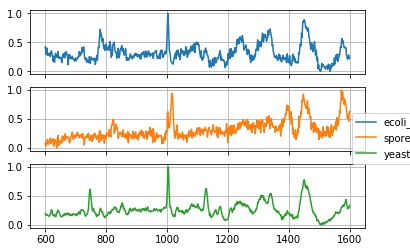

In [108]:
for sample in [coliSamples[0],sporeSamples[0],yeastSamples[0]]:   
    interp=sample.interpolatedSpectra(startWN=startPNT,endWN=endPNT,points=points,removeBackground=True,scale="minmax")
    plt.plot(newX,interp,label=sample.prettyName())
plt.legend(bbox_to_anchor=(1,1))
plt.grid()
plt.show()

fig,axes=plt.subplots(nrows=3,sharex="col")
colors=["C0","C1","C2"]
for idx,sample in enumerate([coliSamples[0],sporeSamples[0],yeastSamples[0]]):   
    interp=sample.interpolatedSpectra(startWN=startPNT,endWN=endPNT,points=points,removeBackground=True,scale="minmax")
    axes[idx].plot(newX,interp,label=sample.prettyName(),color=colors[idx])
    axes[idx].grid(True)
fig.legend(bbox_to_anchor=(1,0.5))
    
plt.show()


In [118]:
allData=sporeSamples+coliSamples+yeastSamples
allSpectra=[]
allClasses=[]
for sample in allData:
    interp=sample.interpolatedSpectra(startWN=startPNT,endWN=endPNT,points=points,scale="minmax",removeBackground=False)
    allSpectra.append(interp)
    allClasses.append(sample.type)
    
allSpectra=np.array(allSpectra)



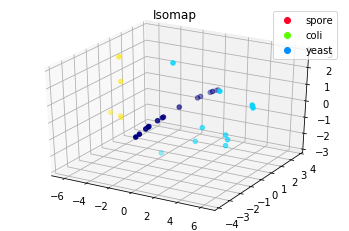

In [119]:
mds=manifold.Isomap(n_components=3)
coords=np.hsplit(mds.fit_transform(allSpectra),3)

plotResult(coords[0],coords[1],coords[2],"Isomap")

In [120]:
numClasses=len(types)

In [121]:
def makeModel(lossFunction="categorical_crossentropy", optimizer="Adam", points=100):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=points))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(numClasses, activation='softmax'))
    if optimizer == "SGD":
        o = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    elif optimizer == "Adam":
        o = Adam()
    model.compile(loss=lossFunction, optimizer=o, metrics=['accuracy'])
    return model

def makeModelCNN(batchNormalize=False,points=100):
    model = Sequential()
    model.add(Conv1D(16,21, input_shape=(points, 1)))
    if batchNormalize is True:
        model.add(BatchNormalization())
        
    model.add(LeakyReLU())
    model.add(MaxPooling1D(2,2))
    
    model.add(Conv1D(32,11))
    if batchNormalize is True:
        model.add(BatchNormalization())
        
    model.add(LeakyReLU())
    model.add(MaxPooling1D(2,2))
    
    model.add(Conv1D(64,5))
    if batchNormalize is True:
        model.add(BatchNormalization())
        
    model.add(LeakyReLU())
    model.add(MaxPooling1D(2,2))
    
    model.add(Flatten())
    model.add(Dense(2048))
    if batchNormalize is True:
        model.add(BatchNormalization())
        
    model.add(Activation("tanh"))
    # model.add(MaxPooling1D(2))
    model.add(Dropout(0.5))
   
    model.add(Dense(numClasses))
    if batchNormalize is True:
        model.add(BatchNormalization())
    model.add(Activation("softmax"))
        
    model.compile(loss="categorical_crossentropy",
                  optimizer='adam',
                  metrics=['accuracy'])
    return model


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1004, 16)          352       
_________________________________________________________________
batch_normalization_1 (Batch (None, 1004, 16)          64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1004, 16)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 502, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 492, 32)           5664      
_________________________________________________________________
batch_normalization_2 (Batch (None, 492, 32)           128       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 492, 32)           0         
__________

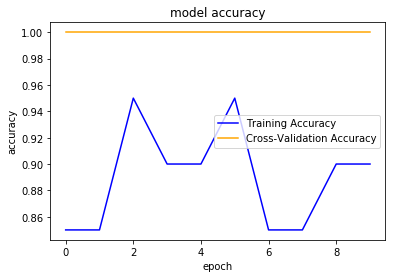

In [122]:
K.clear_session()
oneHotClasses=keras.utils.to_categorical(allClasses,num_classes=numClasses)
xTrain,xTest,yTrain,yTest=model_selection.train_test_split(allSpectra,oneHotClasses,test_size=0.25,stratify=allClasses)

model=makeModelCNN(points=xTrain.shape[1],batchNormalize=True)

print(model.summary())
xTrain=np.expand_dims(xTrain, axis=2)
xTest=np.expand_dims(xTest, axis=2)

history = model.fit(xTrain, yTrain, epochs=10, validation_split=0.1, verbose=1,batch_size=5)
score = model.evaluate(xTest, yTest)
prd = model.predict(xTest)
            
skScore=metrics.accuracy_score(np.argmax(yTest,axis=1),np.argmax(prd,axis=1))
print("Score: {}, SKScore: {}".format(score[1], skScore))
plt.plot(history.history['acc'], color='blue')
plt.plot(history.history['val_acc'], color='orange')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Cross-Validation Accuracy'])
plt.show()

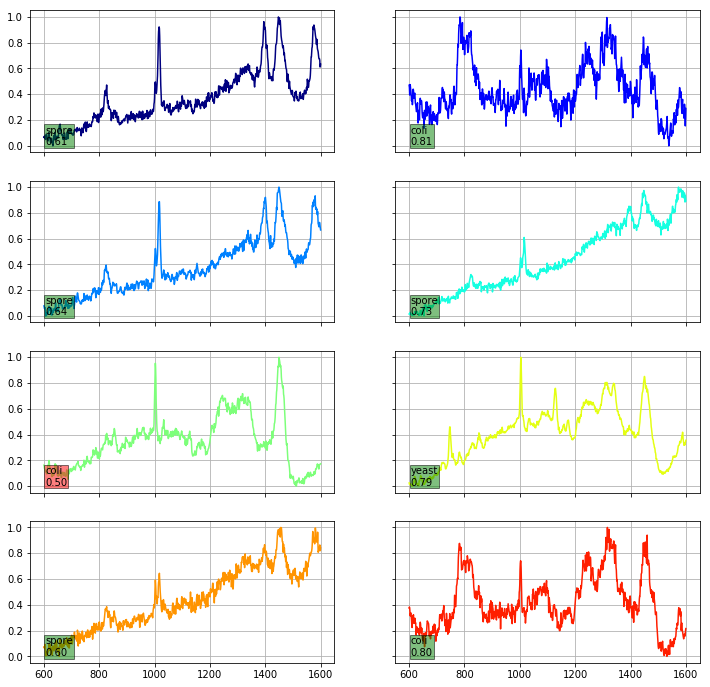

In [123]:
import math
fig,axes = plt.subplots(math.ceil(xTest.shape[0]/2),2,sharex="col", sharey="row",figsize=(12,12))
linearAxes=axes.reshape(-1)
newX=np.linspace(startPNT,endPNT,points)
cmap = plt.cm.get_cmap('jet')
for idx, (spectrum,type) in enumerate(zip(xTest,yTest)):
    ax=linearAxes[idx]
    c=cmap(float(idx)/xTest.shape[0])
    ax.plot(newX,spectrum,color=c)
    ax.grid(True)
    sampleClass=np.argmax(type)
    score=prd[idx,sampleClass]
    if score < 0.5:
        color="red"
    else:
        color="green"
    ax.text(0.05,0.051,"{0}\n{1:.2f}".format(types[sampleClass],score),transform=ax.transAxes,bbox={'facecolor':color, 'alpha':0.5, 'pad':1})
plt.show()


spore 1


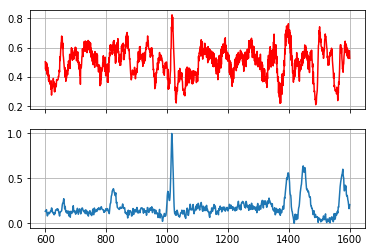

[[0.59554935 0.18328577 0.2211649 ]]
coli 1


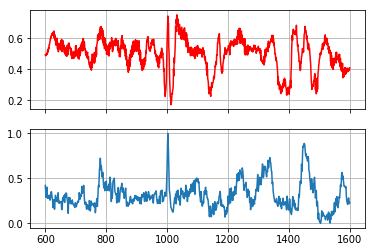

[[0.07735088 0.75568455 0.16696456]]
yeast 1


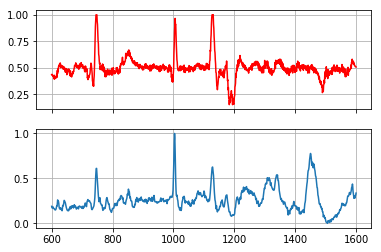

[[0.06524193 0.05882723 0.8759309 ]]


In [115]:
from vis import visualization
from vis.utils import utils
from vis.input_modifiers import Jitter
from keras import activations

tt={1:coliSamples[0],0:sporeSamples[15],2:yeastSamples[0]}
typeTraces={}
for t in tt.keys():
    trace=tt[t].interpolatedSpectra(startPNT,endWN=endPNT,points=points,scale="minmax",removeBackground=True)
    typeTraces[t]=trace

layerName="dense_2"
# layerIDX=utils.find_layer_idx(model=model,layer_name=layerName)
layerIDX=-1
model.layers[layerIDX].activation = activations.linear
model2 = utils.apply_modifications(model)
#model2=model
for type in types.keys():
    for weight in [1]:
    # for weight in [1]:
        
        print(types[type],weight)
        
        maxInput=visualization.visualize_activation(model2,
                                                layer_idx=layerIDX,
                                                filter_indices=[type],
                                                max_iter=100, verbose=False,
                                                input_range=(0., 1.),
                                                tv_weight=weight,
                                                # lp_norm_weight=weight
                                                    )
       
        # maxInput=np.clip(maxInput,0,None)    
        fig,axes=plt.subplots(nrows=2,sharex="col",squeeze=True)
        axes[0].plot(newX,maxInput,color="r")
        axes[1].plot(newX,typeTraces[type],label=type)
        axes[0].grid()
        axes[1].grid()
        
        plt.show()
        
        prd=model.predict(np.reshape(maxInput,(1,maxInput.shape[0],maxInput.shape[1])))
        print(prd)


0
Final loss value: 0.945832


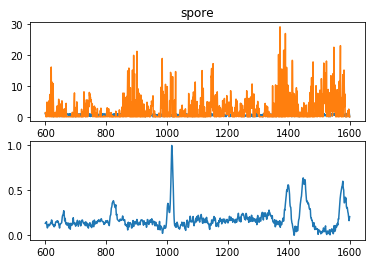

[[0.8082078  0.15127544 0.04051674]]
1
Final loss value: 0.93102026


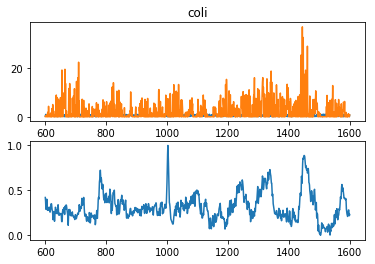

[[0.03973397 0.9199529  0.04031318]]
2
Final loss value: 0.9558065


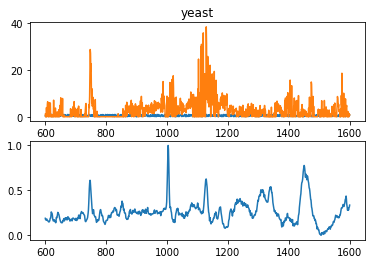

[[0.01728524 0.04017717 0.9425376 ]]


In [124]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
input_img=model.input

for type in types.keys():
    output_index = type
    print(type)
    loss = K.mean(model.output[:, output_index])
    grads = K.gradients(loss, input_img)[0]
    # grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    grads=K.l2_normalize(grads)
    iterate = K.function([input_img], [loss, grads])

    input_img_data = np.random.random((1, points,1))
    originalInput=np.copy(input_img_data)

    

    step = 20 #a parameter to play around with
    loss_value=0
    for i in range(100):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    print('Final loss value:', loss_value)
        
    input_img_data=np.clip(input_img_data,0,None)
    plt.subplot(211)
    plt.plot(newX,originalInput[0,:])
    plt.plot(newX,input_img_data[0,:])
    plt.title(types[type])
    plt.subplot(212)
    plt.plot(newX,typeTraces[type],label=type)
    plt.show()
    prd=model.predict(input_img_data)
    print(prd)



Generative-Adversarial Network

In [484]:
def build_discriminator(points=1024):
    
        model = Sequential()
        model.add(Conv1D(16,21, input_shape=(points, 1)))
        
        model.add(BatchNormalization())
            
        model.add(LeakyReLU())
        model.add(MaxPooling1D(2,2))
        
        model.add(Conv1D(32,11))
        model.add(BatchNormalization())
            
        model.add(LeakyReLU())
        model.add(MaxPooling1D(2,2))
        
        model.add(Conv1D(64,5))
        model.add(BatchNormalization())
            
        model.add(LeakyReLU())
        model.add(MaxPooling1D(2,2))
        
        model.add(Flatten())
        model.add(Dense(2048))
        model.add(BatchNormalization())
            
        model.add(Activation("tanh"))
        # model.add(MaxPooling1D(2))
        model.add(Dropout(0.5))
       
        model.add(Dense(1))
        model.add(BatchNormalization())
        model.add(Activation("sigmoid"))

        model.summary()

        spectrum = Input(shape=(points,1))
        validity = model(spectrum)

        return Model(spectrum, validity)

def build_generator(points=128):
    model = Sequential()
    
    model.add(Dense(128 * 256 , activation="relu", input_dim=points))
    model.add(Reshape((256, 128)))
    model.add(UpSampling1D())
    model.add(Conv1D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling1D())
    model.add(Conv1D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Conv1D(1, kernel_size=3, padding="same"))
   
    model.add(Activation("tanh"))

    model.summary()

    noise = Input(shape=(points,))
    img = model(noise)

    return Model(noise, img)


0.9999999999999999


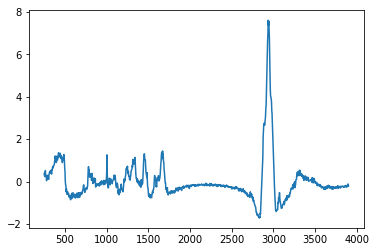

In [485]:
allData=coliSamples
allSpectra=[]
allClasses=[]
startPNT=250
endPNT=3900
newX=np.linspace(250,3900,points)
for sample in allData:
    interp=sample.interpolatedSpectra(startWN=startPNT,endWN=endPNT,points=points,scale="normalize",removeBackground=True)
    allSpectra.append(interp)
    allClasses.append(sample.type)
    
allSpectra=np.array(allSpectra)
plt.plot(newX,allSpectra[0,:])
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1004, 16)          352       
_________________________________________________________________
batch_normalization_1 (Batch (None, 1004, 16)          64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1004, 16)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 502, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 492, 32)           5664      
_________________________________________________________________
batch_normalization_2 (Batch (None, 492, 32)           128       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 492, 32)           0         
__________

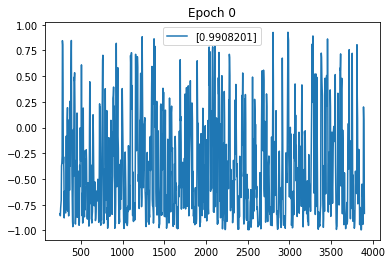

100 [0.31591517, 1.0] 0.8116692


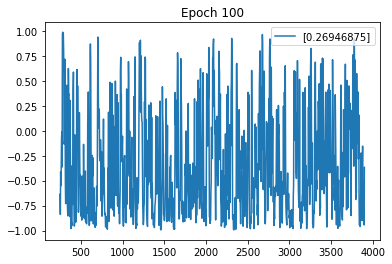

200 [0.31690288, 1.0] 0.8121411


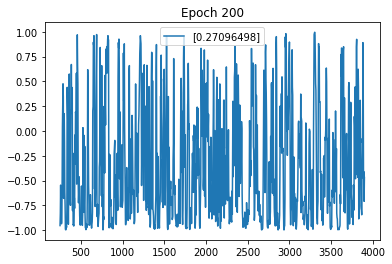

KeyboardInterrupt: 

In [487]:
K.clear_session()

latentDimension=128
batchSize=3
epochs=1000
showSpectraInterval=epochs/10
discriminator=build_discriminator(points=points)
optimizer = Adam(lr=0.00002,beta_1=0.5)
discriminator.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=["accuracy"])
generator=build_generator()
generator.compile(loss='binary_crossentropy', optimizer=Adam())

z = Input(shape=(latentDimension,))
outPut = generator(z)
discriminator.trainable=False
valid = discriminator(outPut)
combined=Model(z,valid)
optimizer = Adam(lr=0.0002,beta_1=0.5)
combined.compile(loss="binary_crossentropy",optimizer=optimizer)
combined.summary()

xTrain=np.expand_dims(allSpectra, axis=2)
valid = np.ones((batchSize, 1))
fake = np.zeros((batchSize, 1))
dtY=np.concatenate((valid,fake))

# valid = np.ones((xTrain.shape[0],1))
# fake = np.zeros((xTrain.shape[0],1))
# noise = np.random.normal(0, 1, (xTrain.shape[0],xTrain.shape[1],1))

# discriminator.fit(dtX,dtY,epochs=10,validation_split=0.1)


for epoch in range(epochs):
    idx = np.random.randint(0, xTrain.shape[0], batchSize)
    currentSpectra = xTrain[idx]
    noise = np.random.normal(0,1,(batchSize,latentDimension))
    generatedSpectra = generator.predict(noise)
    # plt.plot(newX,generatedSpectra[0])
    # plt.show()
    # plt.plot(newX,currentSpectra[0])
    # plt.show()
    
    # generatedSpectra = np.random.normal(0, 1, (batchSize,xTrain.shape[1],1))
    dtX=np.concatenate((currentSpectra,generatedSpectra))
    
    
    # d_loss_fake = discriminator.train_on_batch(generatedSpectra, fake)
    # d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    # d_loss=discriminator.fit(dtX,dtY)
    noise = np.random.normal(0,1,(batchSize,latentDimension))
    
    discriminator.trainable=True
    d_loss_real = discriminator.train_on_batch(dtX, dtY)
    discriminator.trainable=False
    g_loss = combined.train_on_batch(noise,valid)
    
    # print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
    if epoch % showSpectraInterval == 0:
        # print("Epoch {0},[D loss overall: {1}, acc: {2}],G loss".format(epoch, d_loss[0],d_loss[1],g_loss))
        print(epoch,d_loss_real,g_loss)
        nn = np.random.normal(0,1,(batchSize,latentDimension))
        genSp = generator.predict(nn)
        prd=discriminator.predict(genSp)
        plt.plot(newX,genSp[0],label="{}".format(prd[0]))
        title="Epoch {}".format(epoch)
        plt.title(title)
        plt.legend()
        plt.show()
        
prd=discriminator.predict(xTrain)
print(prd)